## **Azure SQL Migration**

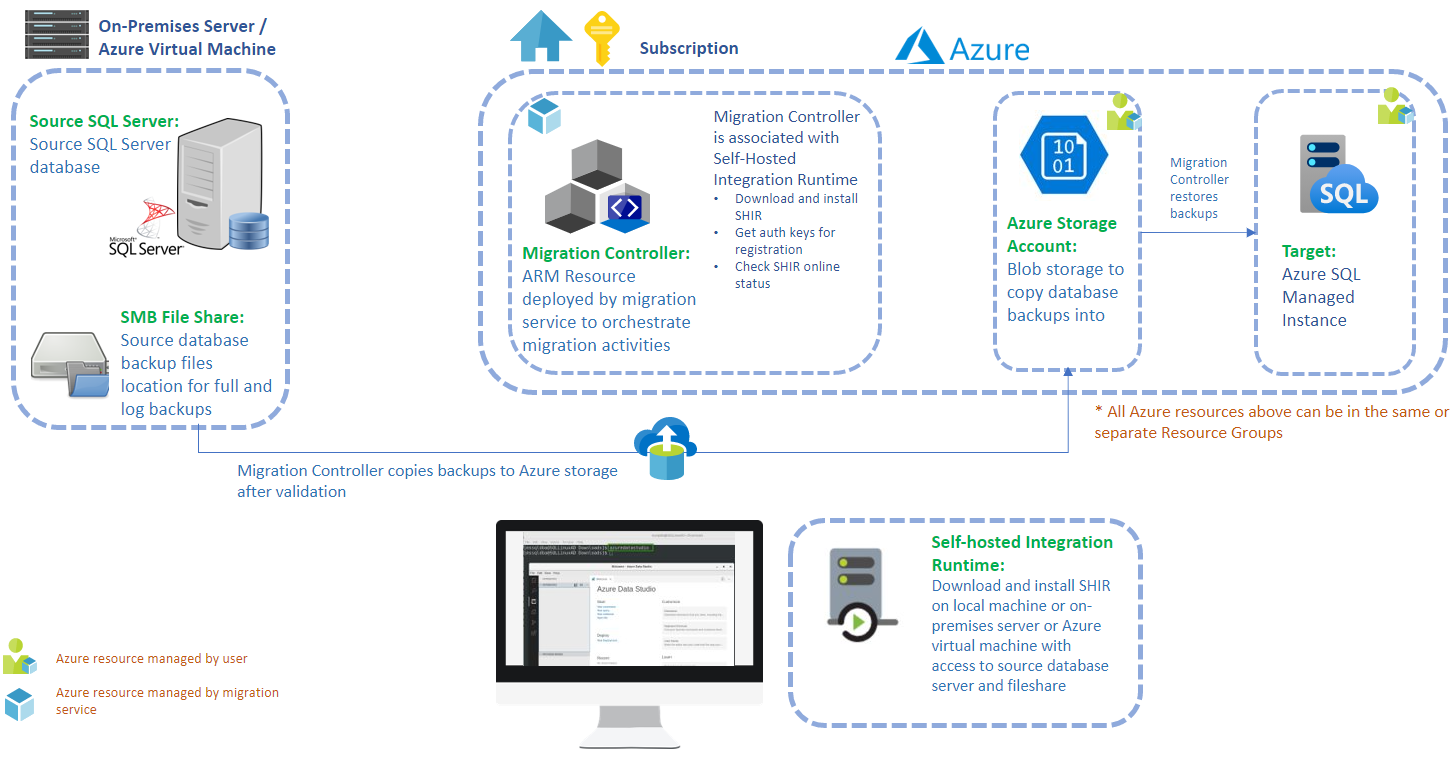

# Azure SQL Migration Steps

1. Check Az PowerShell module
    
2. Input parameters
    
3. Connect to Azure account
    
4. Validate input parameters
    
5. Create Migration Controller
    
6. Download, Install and Register Azure Data Factory (ADF) Self Hosted Integration Runtime (SHIR)
    
7. Start MI online migration
    
8. Monitor ongoing migration
    
9. Initiate migration cutover
    
10. Check status of migrated database
    

      Appendix  
           A) Cancel migration

           B) Delete migration controllers

## 1\. Check Az PowerShell module

Run below code cell to check for powershell version and  if Azure Az powershell module is installed. Reccomand to run this cell with Administrator rights (open ADS as Administrator) . 

This notebook needs Az PowerShell module ([Introducing the Azure Az PowerShell module | Microsoft Docs](https://docs.microsoft.com/powershell/azure/new-azureps-module-az?view=azps-5.3.0))

In [ ]:
# Check if Az PowerShell module is installed
if ($PSVersionTable.PSEdition -eq 'Desktop' -and (Get-Module -Name AzureRM -ListAvailable)) {
    Write-Warning -Message ('Az module not installed. Having both the AzureRM and ' +
      'Az modules installed at the same time is not supported.')
    Write-Warning -Message ('If you want to uninstall AzureRM module, open Azure Data Studio using Run as administrator and run this code cell again ')
    Uninstall-Module AzureRM -AllVersions
} 

if( !(Get-Module -Name AnyBox) ){
   Write-Output "installing AnyBox module"
   Install-Module -Name AnyBox -RequiredVersion 0.3.4 -Force
   Import-Module AnyBox
}

$version = [System.Version]::Parse("5.3.0")

$AzModule = Get-InstalledModule -Name Az -ErrorAction:Ignore
if( !$AzModule ){
  Write-Output "No Azure Powershell modue was found"
  Write-Output "This requires Admin rights: force to install or update Azure PowerShell Modules with the latest version..."
  Install-Module -Name Az -AllowClobber -Force 
}else{
   $AzVersion = $AzModule.Version
   if( $AzVersion -and $AzVersion -ge $version){
     Write-Output "You have Azure Module installed already, version is $AzVersion "
   }else{
     Write-Output "Your Azure Module version is $AzVersion, lower than the required version  $version"
     Write-Output "This requires Admin rights: force to install or update Azure PowerShell Modules with the latest version..."
     Install-Module -Name Az -AllowClobber -Force
   }
}

## 2\. Input parameters

Please provide values for all the parameters in below code cell and run it. The values will be used for performing migration to Azure SQL Managed Instance.

In [ ]:
<#=====================================================================================================================================================
Azure Subscription and Tenant ID
=====================================================================================================================================================#>

# Input Azure Subscription ID 
$subscription            = ""
# Input Azure Active Directory Tenant ID (Find Tetant ID through Azure Portal https://docs.microsoft.com/azure/active-directory/fundamentals/active-directory-how-to-find-tenant#find-tenant-id-through-the-azure-portal)
$tenantID                = "" 



<#=====================================================================================================================================================
Source SQL Server database 
=====================================================================================================================================================#>

# Input source SQL Server instance name
$SourceSQLServer         = "" 
# Input source SQL Server database name
$SourceDbName            = ""
# Choose SQL Server authentication mode. Valid values:  "WindowsAuthentication" , "SqlAuthentication" 
$Authentication          = "SqlAuthentication"
# Input source SQL Server user name. Fill in remaining parameters and run this code cell to enter password. 
$SourceSQLServerUserName = ""



<#=====================================================================================================================================================
File share 
=====================================================================================================================================================#>

# Input file share path where database backup files exits
$FileSharePath           = ""
# Input user name that has read access to file share. Fill in remaining parameters and run this code cell to enter password.  
$FileShareUserName       = ""



<#=====================================================================================================================================================
Target Azure SQL Managed Instance (MI) 
=====================================================================================================================================================#>

# Input Resource Group name that contains target MI 
$MIRgName           = ""                                   
# Input target MI name
$MIName             = ""
# Input target MI database name . Azure Database Migration service (DMS) will create the target database. 
$TargetDbName       = ""                           


<#=====================================================================================================================================================
Azure Storage Account
=====================================================================================================================================================#>

# Input Resorce Group name that contains the Storage Account where backup files will be copied to. 
$StorageRgName      = ""
# Input Storage Account name where bakcup files will be copied to.
$StorageAccountName = ""                           


<#=====================================================================================================================================================
Migration Mode
=====================================================================================================================================================#>

# Choose migration mode. Valid values: "online" , "offline"
$MigrationMode           = "online"                                                        


<#=====================================================================================================================================================
Migration Controller
=====================================================================================================================================================#>

# Input Resoruce Group to be used for creating Migration Controller. If Resource Group doesn't exist then it will be created. 
$ResourceGroupName  = ""
# Input the name of  Migration Controller to be created. 
$ControllerName     = ""                   
# Input Azure location for the Migration Controller resource. Valid values: "eastus2euap"
$Location           = ""                      

<#=====================================================================================================================================================
Following code will let you enter password for SQL Server user and file share user. 
=====================================================================================================================================================#>
Import-Module AnyBox
$anybox = New-Object AnyBox.AnyBox
$anybox.Prompts = @(
  New-AnyBoxPrompt -Name 'SourceServerPassword' -Message "Enter password for SQL Server user ""$SourceSQLServerUserName"" "  -ValidateNotEmpty -InputType Password
  New-AnyBoxPrompt -Name 'FilesharePassword' -Message "Enter password for file share user ""$FileShareUserName"" " -ValidateNotEmpty -InputType Password
)
$anybox.Buttons = @(
    New-AnyBoxButton -Name 'submit' -Text 'Submit' -IsDefault
)
$anybox.ContentAlignment = 'Left'
$response = $anybox | Show-AnyBox
$SourceSQLServerPasswordS = $response['SourceServerPassword']
$FileSharePasswordS = $response['FilesharePassword']
$SourceBSTR = [System.Runtime.InteropServices.Marshal]::SecureStringToBSTR($SourceSQLServerPasswordS)
$FileShareBSTR = [System.Runtime.InteropServices.Marshal]::SecureStringToBSTR($FileSharePasswordS)
$SourceSQLServerPassword = [System.Runtime.InteropServices.Marshal]::PtrToStringAuto($SourceBSTR)
$FileSharePassword = [System.Runtime.InteropServices.Marshal]::PtrToStringAuto($FileShareBSTR)
$HostName = "https://" + $Location + ".management.azure.com"
$APIversion = "api-version=2020-09-01-preview"

## 3\. Connect to Azure Account

Run below code cell to:

-   Connect to an Azure connect
    
-   Check if resource group and storage account where backup files will be copied to exists. Get the storage account key.
    
-   Check if resource group for Azure Data Migration Service (DMS) Migration Controller exists. 
    
-   Register Azure Data Migration Service (DMS) Migration Controller resource type

In [ ]:
# Connect to Azure Subscription
Connect-AzAccount -Subscription $subscription -Tenant $tenantID

$StorageAccount = Get-AzStorageAccount -Name $StorageAccountName -ResourceGroupName $StorageRgName -ErrorAction Ignore
if (!$StorageAccount)
{
    Write-Output "Storage Account $StorageAccountName in resource group $StorageRgName does not exist."
    Write-Output "Please check the storage account information and run this cell again"
}
else
{
    Write-Output "Storage Account $StorageAccountName already exists"
    # Get the storage account key
    $StorageAccountKeyObj = Get-AzStorageAccountKey -ResourceGroupName $StorageRgName -Name $StorageAccountName
    $StorageAccountKey = $StorageAccountKeyObj.Value[0]
    $StorageAccountResourceId = "/subscriptions/" + $subscription + "/resourceGroups/" + $StorageRgName + "/providers/Microsoft.Storage/storageAccounts/" + $StorageAccountName
}

# Check if Resoruce Group for Migration Controller exists. If it doesn't exist then create it
$rg = Get-AzResourceGroup | Where ResourceGroupName -eq $ResourceGroupName
if (!$rg)
{
    # Need to create a new resource group
    Write-Output "Resource Group $ResourceGroupName does not exist. Creating..."
    $rg = New-AzResourceGroup -Name $ResourceGroupName -Location $Location
    if( !$rg ){
        Write-Output "Creating Resource Group $ResourceGroupName failed. Check your permission in the subscription $subscription"
    }else{
        Write-Output "Resource Group $ResourceGroupName has been created"
    }
}else{
    Write-Output "Resource Group $ResourceGroupName exists."
}

# Check if Azure Database Migration Service (DMS) Migration Controller resource is registered in the subscription. 
if (Get-AzResource -ResourceType Microsoft.DataMigration/Controllers) {
    Write-Output "Azure Database Migration Service (DMS) Migration Controller resource type is already registered in the subscription"
}else{
    Write-Output "Registering Azure Database Migration Service (DMS) Migration Controller resource type in the subscription"
    if(Get-AzResourceProvider -ProviderNamespace Microsoft.DataMigration){
        Unregister-AzResourceProvider -ProviderNamespace Microsoft.DataMigration
    }
    Register-AzResourceProvider -ProviderNamespace Microsoft.DataMigration
    if( (Get-AzResourceProvider -ProviderNamespace Microsoft.DataMigration).ResourceTypes | Where-Object ResourceTypeName -eq Controllers ){
        Write-Output "Azure Database Migration Service (DMS) Migration Controller resource type has been registered in the subscription"
    }else{
        Write-Output "Azure Database Migration Service (DMS) Migration Controller resource type registration failed."
    }
}

## 4\. Validate input parameters

Run this code cell to perform following validations:

- Ensure this machine can connect to source SQL Server. Assuming the Azure Data Factory (ADF) Self Hosted Integration Runtime (SHIR) is installed in this local machine. 
- Ensure this machine has access to fileshare. Assuming the ADF SHIR is installed in this local machine. 
- Ensure the target Azure SQL Managed Instance exists

In [ ]:
# Test Connection to  source SQL Server.
Write-Output "Checking  connection to source SQL Server instance $SourceSQLServer ..."
if($Authentication -eq "WindowsAuthentication"){
    $ParseNameInstance = $SourceSQLServer -split '\',-1,'SimpleMatch'
    $SourceServerName = $ParseNameInstance[0]
    [securestring]$secSourcePasswordSql = ConvertTo-SecureString $SourceSQLServerPassword -AsPlainText -Force
    [pscredential]$credObjectSql = New-Object System.Management.Automation.PSCredential ($SourceSQLServerUserName, $secSourcePasswordSql)
    $TestDriveSql = New-PSDrive TestSql -PSProvider FileSystem -Root "\\$SourceServerName\c$" -Credential $credObjectSql
    if(!$TestDriveSql){
        Write-Output "Connection from this machine to source SQL Server instance failed" 
    }else{
        Write-Output "Connection from this machine to source SQL Server instance succeeded"
    }
    Remove-PSDrive TestSql
    Remove-SmbMapping -Force -ErrorAction Ignore
}
else{
    $AuthTyp = ""
    switch ($Authentication){
        "SqlAuthentication" { $AuthTyp = ""; break}
        "ActiveDirectoryIntegrated" { $AuthTyp = "Active Directory Integrated"; break}
        "ActiveDirectoryPassword" { $AuthTyp = "Active Directory Password"; break}
        default { Write-Output "Unvalid input of authentication type" }
    }
    #$Authentication -eq "SqlAuthentication" ;Authentication={4} ,$AuthTyp
    $AuthTyp
    $connectionString = 'Data Source={0};database={1};User ID={2};Password={3};Authentication={4}' -f $SourceSQLServer,$SourceDbName,$SourceSQLServerUserName,$SourceSQLServerPassword,$AuthTyp
    $sqlConnection = New-Object System.Data.SqlClient.SqlConnection $connectionString
    try{
        $sqlConnection.Open()
        $sqlConnection.Close()
        Write-Output "Connection from this machine to source SQL Server instance succeeded" 
    } catch {
        Write-Output "Connection from this machine to source SQL Server instance failed" 
    }
}

# Test Connection to file share path 
Write-Output "Checking connection to file share path $FileSharePath ..."
[securestring]$secStringPassword = ConvertTo-SecureString $FileSharePassword -AsPlainText -Force
[pscredential]$credObject = New-Object System.Management.Automation.PSCredential ($FileShareUserName, $secStringPassword)
$TestDrive = New-PSDrive Test -PSProvider FileSystem -Root $FileSharePath -Credential $credObject
if(!$TestDrive){
    Write-Output "Connection from this machine to file share path failed"
}else{
    Write-Output "Connection from this machine to file share path succeeded"
}
$LastBackupName = ""
$filenames = (Get-ChildItem -Path $FileSharePath).Name
foreach ($item in $filenames){
   $extn = [IO.Path]::GetExtension($item)
   if ($extn -eq ".bak" ){
       $LastBackupName = $item
       break;
   }
}
if ( !$LastBackupName -and $MigrationMode -eq "offline"){
    Write-Warning -Message ('No database backup file was found in file share path')
}
Remove-PSDrive Test
Remove-SmbMapping -Force -ErrorAction Ignore

# Validate target MI exists
Write-Output "Checking the Managed Instance target server $MIName in resource group $MIRgName ..." 
$MIInstanceObj = Get-AzSqlInstance -ResourceGroupName $MIRgName -Name $MIName
if(!$MIInstanceObj){
    Write-Output "Target Managed Instance does not exist." 
}else{
    Write-Output "Target Managed Instance exists."
}

## 5\. Create DMS Migration Controller

Migration Controller in an Azure ARM (Azure Resource Manager) resource created in the subscription and it is needed to coordinate and monitor data migration activities.

### 5.1 Run below code cell to create a Migration Controller

In [ ]:
# Create Migration Controller
$ControllersRescourceId = "/subscriptions/" + $subscription + "/resourceGroups/" + $ResourceGroupName + "/providers/Microsoft.DataMigration/Controllers/" + $ControllerName
$CtlRequestBody = '
{
"location": null
}' | ConvertFrom-Json
$CtlRequestBody.location=$Location 
$CtlRequestBodyJson = $CtlRequestBody | ConvertTo-Json
$ControllersURL = $HostName +  $ControllersRescourceId + "?" + $APIversion
$tokentext = (Get-AzAccessToken).Token
$headers = @{Authorization="Bearer $tokentext"}
$ResponseOfCtlPUT = Invoke-WebRequest -Uri $ControllersURL -Header $headers -Method PUT -Body $CtlRequestBodyJson  -ContentType "application/json"  -UseBasicParsing
Write-Output "Response for Migration Controller creation: "
$ResponseOfCtlPUT


### 5.2 Run below code cell to get creation status for Migration Controller

In [ ]:
# Check Migration Controller creation status
$tokentext = (Get-AzAccessToken).Token
$headers = @{Authorization="Bearer $tokentext"}
$ResponseOfCtlGET = Invoke-RestMethod -Uri $ControllersURL -Header $headers -Method GET -ContentType "application/json" -UseBasicParsing
$ResponseOfCtlGET | ConvertTo-Json
if ( $ResponseOfCtlGET.properties.isProvisioned ){
   if($ResponseOfCtlGET.properties.integrationRuntimeState -eq "NeedRegistration"){
      Write-Output "Migration Controller has been provisioned. Run code in step 5.3 to get authentication keys and register Azure Data Factory (ADF) Self Hosted Integration Runtime (SHIR)"
   }else{
      Write-Output "Migration Controller has been provisioned and registered with Azure Data Factory (ADF) Self Hosted Integration Runtime (SHIR). Run code in step 7 to start migration"
   }
} else {
     Write-Output "Migration Controller is still being provisioned. Check the status again in a moment..."
}

### 5.3 Run below code cell to list Migration Controller's authentication keys, needed for registering Azure Data Factory (ADF) Self Hosted Integration Runtime (SHIR)

In [ ]:
# Get Migration Controller's authentication keys, needed for registering Azure Data Factory (ADF) Self Hosted Integration Runtime (SHIR)
$ListAuthkeysURL = $HostName +  $ControllersRescourceId + "/ListAuthKeys" + "?" + $APIversion
$tokentext = (Get-AzAccessToken).Token
$headers = @{Authorization="Bearer $tokentext"}
$ResponseOfListAuthkeys = Invoke-RestMethod -Uri $ListAuthkeysURL -Header $headers -Method POST -ContentType "application/json" -UseBasicParsing
Write-Output "Use one of the two authetication keys to register Azure Data Factory (ADF) Self Hosted Integration Runtime (SHIR)"
$ResponseOfListAuthkeys.keyName1
$ResponseOfListAuthkeys.keyName2

## 6\. Download, Install and Register Azure Data Factory (ADF) Self Hosted Integration Runtime (SHIR)

### 6.1 Download, install and register ADF SHIR

Download and install ADF SHIR on this machine ([Download Microsoft Integration Runtime from Official Microsoft Download Center](https://www.microsoft.com/download/details.aspx?id=39717))

On the Register Integration Runtime (Self-hosted) page, paste the key you saved earlier (Step 5.3), and select Register.

![Register the integration runtime](https://docs.microsoft.com/azure/data-factory/media/create-self-hosted-integration-runtime/register-integration-runtime.png)

<span style="background-color: rgb(255, 255, 255); color: rgb(23, 23, 23); font-family: &quot;Segoe UI&quot;, SegoeUI, &quot;Helvetica Neue&quot;, Helvetica, Arial, sans-serif; font-size: 16px;">After the self-hosted integration runtime is registered successfully, you see the following window:</span>  

![Successful registration](https://docs.microsoft.com/azure/data-factory/media/create-self-hosted-integration-runtime/registered-successfully.png)

### 6.2 Run below code cell to check whether ADF SHIR is online

In [ ]:
# Check the status of ADF SHIR
$tokentext = (Get-AzAccessToken).Token
$headers = @{Authorization="Bearer $tokentext"}
$ResponseOfCtlGET = Invoke-RestMethod -Uri $ControllersURL -Header $headers -Method GET -ContentType "application/json" -UseBasicParsing
$ResponseOfCtlGET | ConvertTo-Json
if ( $ResponseOfCtlGET.properties.integrationRuntimeState -eq "Online" ){
    Write-Output "Azure Data Factory (ADF) Self Hosted Integration Runtime (SHIR) is ONLINE. Run code in step 7 to start migration"
} else {
    Write-Output "Azure Data Factory (ADF) Self Hosted Integration Runtime (SHIR) is NOT ONLINE."
}

## 7\. Start MI migration

Run below code cell to start the migration.

In [ ]:
#Start MI migration
$MIRequestBody = '
{
      "location": null,
      "properties": {
        "SourceDatabaseName": null,
        "MigrationController": null,
        "AutoCutoverConfiguration": null,
        "BackupConfiguration": {
          "TargetLocation": {
            "StorageAccountResourceId": null,
            "AccountKey": null
          },
          "SourceLocation": {
            "FileShare": {
              "Path": null,
              "Username": null,
              "Password": null
            }
          }
        },
        "SourceSqlConnection": {
          "DataSource": null,
          "UserName": null,
          "Password": null,
          "Authentication": null
        },
        "Scope": null
      }
}' | ConvertFrom-Json

$AutoCutoverConfiguration = '
{
 "LastBackupName": null
}' | ConvertFrom-Json

$MIRequestBody.location = $Location
$MIRequestBody.properties.SourceDatabaseName = $SourceDbName
$MIRequestBody.properties.MigrationController = $ControllersRescourceId 
$MIRequestBody.properties.BackupConfiguration.TargetLocation.StorageAccountResourceId = $StorageAccountResourceId
$MIRequestBody.properties.BackupConfiguration.TargetLocation.AccountKey = $StorageAccountKey
$MIRequestBody.properties.BackupConfiguration.SourceLocation.FileShare.Path = $FileSharePath
$MIRequestBody.properties.BackupConfiguration.SourceLocation.FileShare.Username = $FileShareUserName
$MIRequestBody.properties.BackupConfiguration.SourceLocation.FileShare.Password = $FileSharePassword
$MIRequestBody.properties.SourceSqlConnection.DataSource = $SourceSQLServer
$MIRequestBody.properties.SourceSqlConnection.UserName = $sourceSQLServerUserName
$MIRequestBody.properties.SourceSqlConnection.Password = $sourceSQLServerPassword
$MIRequestBody.properties.SourceSqlConnection.Authentication = $Authentication
$MIRequestBody.properties.Scope = "/subscriptions/" + $subscription + "/resourceGroups/" + $MIRgName + "/providers/Microsoft.Sql/managedInstances/" + $MIName

if($MigrationMode -eq "offline"){
    $AutoCutoverConfiguration.LastBackupName = $LastBackupName
    $properties.AutoCutoverConfiguration= $AutoCutoverConfiguration
}

$MIRequestBodyJson = $MIRequestBody | ConvertTo-Json -Depth 5

$MIMigrationRescourceId = "/subscriptions/" + $subscription + "/resourceGroups/" + $MIRgName + "/providers/Microsoft.Sql/managedInstances/" + $MIName + "/providers/Microsoft.DataMigration/databaseMigrations/" + $TargetDbName

$MIMigrationURL = $HostName +  $MIMigrationRescourceId + "?" + $APIversion
$tokentext = (Get-AzAccessToken).Token
$headers = @{Authorization="Bearer $tokentext"}
$ResponseOfCMIMigrationPUT = Invoke-WebRequest -Uri $MIMigrationURL -Header $headers -Method PUT -Body $MIRequestBodyJson -ContentType "application/json" -UseBasicParsing
 
Write-Output "View the response of PUT request"
$ResponseOfCMIMigrationPUT

## 8\. Monitor ongoing migration

Run below code sell to check the detailed status of database migration . Time taken for migration will depend on number of files and their size.  
Periodically run this cell until all backup files are restored.

In [ ]:
# Monitor ongoing migration
$MIMigrationGETURL = $HostName +  $MIMigrationRescourceId + "?" + "$" + "expand=MigrationStatusDetails&" + $APIversion
$tokentext = (Get-AzAccessToken).Token
$headers = @{Authorization="Bearer $tokentext"}
$ResponseOfCMIMigrationGET = Invoke-RestMethod -Uri $MIMigrationGETURL -Header $headers -Method GET -ContentType "application/json" -UseBasicParsing

Write-Output "View the whole response: "
$ResponseOfCMIMigrationGET | ConvertTo-Json
Write-Output "Backup file status details: "
$html = $ResponseOfCMIMigrationGET.properties.migrationStatusDetails.activeBackupSets
$htmlSelect = $html | Select-Object -Property @{Name="fileName"; E={$_.listOfBackupFiles.fileName}}, @{Name="fileStatus"; E={$_.listOfBackupFiles.status}}, backupType, isBackupRestored
$htmlSelect | Format-Table 
$operationid = $ResponseOfCMIMigrationGET.properties.migrationOperationId
if( $ResponseOfCMIMigrationGET.properties.migrationStatusDetails.isFullBackupRestored ){
    Write-Output "All the backup files have been restored. Run code in step 9.1 to initiate migration cutover."
}else {
    Write-Output "Backup files are being restored..."
}


## 9\. Initiate migration cutover

### 9.1 Run below code cell to intiate migration cutover.

In [ ]:
# Initiate migration cutover
$MIMigrationCutoverURL = $HostName +  $MIMigrationRescourceId +"/operations/" + $operationid + "/cutover?" + $APIversion
$tokentext = (Get-AzAccessToken).Token
$headers = @{Authorization="Bearer $tokentext"}
$ResponseOfCMICutover = Invoke-WebRequest -Uri $MIMigrationCutoverURL -Header $headers -Method POST -ContentType "application/json" -UseBasicParsing
# View the reponse of cutover request
$ResponseOfCMICutover


### 9.2 Run below code cell to ensure cutover has succeeded.

In [ ]:
# Confirm cutover has succeeded
$tokentext = (Get-AzAccessToken).Token
$headers = @{Authorization="Bearer $tokentext"}
$ResponseOfCMIMigrationGET = Invoke-RestMethod -Uri $MIMigrationGETURL -Header $headers -Method GET -ContentType "application/json"  -UseBasicParsing
Write-Output "Status of migration cutover"
$ResponseOfCMIMigrationGET | ConvertTo-Json
if($ResponseOfCMIMigrationGET.properties.migrationStatus -eq "Succeeded"){
    Write-Output "Migration has succeeded."
}else{
    Write-Output "Migration cutover is in progress. Check the status again in a moment... "
}
# loop in the above code cell after a few mins? 


## 10\. Check status of migrated database

Run below code cell to check status of the migrated database.

In [ ]:
# Check the status of target database after migration
Write-Output "Check the status of target database after migration"
Get-AzSqlInstanceDatabase -Name $TargetDbName -InstanceName $MIName -ResourceGroupName $MIRgName

## Appendix

### A) Cancel migration

Run below code cell if there is a need to cancel an ongoing migration.

In [ ]:
$MIMigrationCancelURL = $HostName +  $MIMigrationRescourceId +"/operations/" + $operationid + "/cancel?" + $APIversion
$tokentext = (Get-AzAccessToken).Token
$headers = @{Authorization="Bearer $tokentext"}
$ResponseOfCMICancel = Invoke-WebRequest -Uri $MIMigrationCancelURL -Header $headers -Method POST -ContentType "application/json" -UseBasicParsing
# View the reponse of Cancel request
$ResponseOfCMICancel

### B) Delete migration controllers

Run below code cell if there is a need to delete an migration controller

In [ ]:
$tokentext = (Get-AzAccessToken).Token
$headers = @{Authorization="Bearer $tokentext"}
$ResponseOfCtlDELETE = Invoke-WebRequest -Uri $ControllersURL -Header $headers -Method Delete -ContentType "application/json" -UseBasicParsing
$ResponseOfCtlDELETE